# fMRI example

In [25]:
%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from scipy.io import loadmat
from os.path import join
import glob
import pandas as pd
import tensorflow as tf 
from sklearn import svm
from sklearn.metrics import accuracy_score
from scipy import stats 

In [5]:
#data dir test 
data_dir = '../data/greco_mri'
behav_dir = '../data/greco_behav'

#rois
rois = ['left_CA1','right_CA1','left_DG','right_DG'];

#subjec list
ubjects = np.array(['S1_A','S2_B','S3_A','S4_A','S5_A','S6_A','S7_A','S8_B',
            'S9_A','S10_B','S11_B','S12_B','S13_B','S14_B','S15_B',
            'S16_A','S21_B','S22_B','S24_A']);

In [ ]:
def center_normalize(x):
    x_mean_rows = np.mean(x,1).reshape(x.shape[0],1)
    x_std_rows = np.std(x,1).reshape(x.shape[0],1)
    return (x - x_mean_rows) / x_std_rows

def onehot(y):
    ynp=np.array(y)
    y_onehot=[0]*len(ynp)
    for i,j in enumerate(ynp):
        y_onehot[i]=[0]*ynp.max()
        y_onehot[i][j-1]=1
        
    return y_onehot
def recode20(y):
    y_r = np.empty(y.shape)
    y_r[y == 1] = 0
    y_r[y == 2] = 1
    y_r[y == 3] = 2
    return y_r

   
def get_results_all(reg,svm,nn):
    print('Logistic regression')
    print('mean accuracy: ' + str(np.mean(reg)))
    print('Logistic regression (1samp ttest):')
    print(stats.ttest_1samp(np.mean(scores_reg,1),.33))
    print
    print('SVM')
    print('mean accuracy: ' + str(np.mean(svm)))
    print('1samp ttest:')     
    print(stats.ttest_1samp(np.mean(scores_svm,1),.33))
    print
    print('Neural network')
    print('mean accuracy: ' + str(np.mean(nn)))
    print('1samp ttest:')
    print(stats.ttest_1samp(np.mean(scores_nn,1),.33))
def get_results_nn(nn):
    print('Neural network')
    print('mean accuracy: ' + str(np.mean(scores_nn)))
    print('1samp ttest:')
    print(stats.ttest_1samp(np.mean(scores_nn,1),.33))
    
def model_svm(x_train,y_train,x_test,y_test):
    C = 1  # SVM regularization parameter
    svc = svm.LinearSVC(C=C).fit(x_train, y_train)
    y_pred = svc.predict(x_test)
    return accuracy_score(y_test, y_pred)

def model_tf_regression(x_train,y_train,x_test,y_test):
    tf.reset_default_graph()
    sess = tf.InteractiveSession()

    x = tf.placeholder(tf.float32, shape=[None, x_train.shape[1]])
    y_ = tf.placeholder(tf.float32, shape=[None, 3])


    W = tf.Variable(tf.zeros([x_train.shape[1],3]))
    b = tf.Variable(tf.zeros([3]))

    sess.run(tf.global_variables_initializer())

    y = tf.matmul(x,W) + b

    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    
    ##train
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    for i in range(1000):
        train_step.run(feed_dict={x: x_train.tolist(), y_: onehot(y_train)})
    
    #tf.argmax gives an index of the highest entry in a tensor along some axis
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

    #we can take this list of booleans and calculate the fraction correct
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return accuracy.eval(feed_dict={x: x_test.tolist(), y_: onehot(y_test)})
    sess.close()


In [ ]:
def model_tf_nn_mult(x_train,y_train,x_test,y_test,num_nodes,n_epochs):
    tf.reset_default_graph()

    n_inputs = x_train.shape[1]
    n_outputs = 3
    learning_rate = 0.01

    n_hidden1=num_nodes[0]
    n_hidden2=num_nodes[1]
    n_hidden3=num_nodes[2]
    def neuron_layer(X, n_neurons, name, activation=None):
        with tf.name_scope(name):
            n_inputs = int(X.get_shape()[1])
            stddev = 1 / np.sqrt(n_inputs)
            init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
            W = tf.Variable(init, name="weights")
            b = tf.Variable(tf.zeros([n_neurons]), name="biases")
            Z = tf.matmul(X, W) + b
            if activation=="relu":
                return tf.nn.relu(Z)
            else:
                return Z
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
    y = tf.placeholder(tf.int64, shape=(None), name="y")
    with tf.name_scope("dnn"):
        hidden1 = neuron_layer(X, n_hidden1, "hidden1", activation="relu")
        if n_hidden2 ==0:
            logits = neuron_layer(hidden1, n_outputs, "output")
        elif n_hidden3 ==0:
            hidden2 = neuron_layer(hidden1, n_hidden2, "hidden2", activation="relu")
            logits = neuron_layer(hidden2, n_outputs, "output")
        else: 
            hidden2 = neuron_layer(hidden1, n_hidden2, "hidden2", activation="relu")
            hidden3 = neuron_layer(hidden2, n_hidden3, "hidden2", activation="relu")
            logits = neuron_layer(hidden3, n_outputs, "output")
            
    with tf.name_scope("loss"):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

    with tf.name_scope("train"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        prediction=tf.argmax(logits,1)
            
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
#     n_epochs = 50
    acc_test_high = 0.0
    epoch_high = 0
    sess = tf.InteractiveSession()

    sess.run(init)
    predictions = np.empty(x_test.shape[0])
    for epoch in range(n_epochs):
        for i in range(x_train.shape[0]):
            x_data = x_train[i,:].reshape([1,x_train.shape[1]])
            y_data = np.array([y_train[i]])
            sess.run(training_op, feed_dict={X: x_data, y: y_data })
        
        acc_train = accuracy.eval(feed_dict={X: x_train, y: y_train})
        acc_test = accuracy.eval(feed_dict={X: x_test, y: y_test})
        if acc_test > acc_test_high:
            acc_test_high = acc_test
            epoch_high = epoch
            predictions = prediction.eval(feed_dict={X: x_test})
#   print(epoch_high, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

    # save_path = saver.save(sess, "./one_layer.ckpt")
    return acc_test_high,predictions,epoch_high
    sess.close()


In [20]:
 def batch_nn(node_array,epochs):
    scores_svm = np.empty([subjects.shape[0],4])
    scores_reg = np.empty([subjects.shape[0],4])
    scores_nn = np.empty([subjects.shape[0],4])
    nn_high_epoch = np.empty([subjects.shape[0],4])
    ind_scores_nn_y_pred= []
    ind_scores_subj = []
    ind_scores_run = [] 
    ind_scores_y_test =[]

    for i,subj in enumerate(subjects):
        for run in [0,1,2,3]:

            behav = pd.read_table(join(behav_dir,subj,subj + '.txt'))

            fname = join(data_dir,subj + '_right_DG.csv')
            betas= pd.read_csv(fname,header=None)

            test_ind   = behav['run_num'] == run
            train_ind  = behav['run_num'] != run
            y_test     = behav['currCity'][test_ind].as_matrix()        
            y_test_r   = recode20(y_test)

            y_train    = behav['currCity'][train_ind].as_matrix()
            y_train_r  = recode20(y_train)

            x_test = center_normalize(betas[test_ind].as_matrix())
            x_train = center_normalize(betas[train_ind].as_matrix())

            nn_acc,nn_y_pred,nn_epoch = model_tf_nn_mult(x_train,y_train_r,x_test,y_test_r,node_array,epochs)
            scores_nn[i,run] = nn_acc
            nn_high_epoch[i,run] = nn_epoch
            for idx,resp in enumerate(y_test):
                ind_scores_y_test.append(resp)
                ind_scores_subj.append(subj)
                ind_scores_nn_y_pred.append(nn_y_pred[idx] + 1)
                ind_scores_run.append(run)

#build data frames
    nn_scores_ind_df = pd.DataFrame({'subject'  : ind_scores_subj,
                         'run'      : ind_scores_run,
                         'city'     : ind_scores_y_test,
                         'city_pred': ind_scores_nn_y_pred})            


    
    
    return nn_scores_ind_df,scores_nn,nn_high_epoch

### Three models with cross validation

In [24]:
scores_svm = np.empty([subjects.shape[0],4])
scores_reg = np.empty([subjects.shape[0],4])
scores_nn = np.empty([subjects.shape[0],4])
nn_high_epoch = np.empty([subjects.shape[0],4])
ind_scores_nn_y_pred= []
ind_scores_subj = []
ind_scores_run = [] 
ind_scores_y_test =[]

for i,subj in enumerate(subjects):
    for run in [0,1,2,3]:

        behav = pd.read_table(join(behav_dir,subj,subj + '.txt'))

        fname = join(data_dir,subj + '_right_DG.csv')
        betas= pd.read_csv(fname,header=None)

        test_ind   = behav['run_num'] == run
        train_ind  = behav['run_num'] != run
        y_test     = behav['currCity'][test_ind].as_matrix()        
        y_test_r   = recode20(y_test)

        y_train    = behav['currCity'][train_ind].as_matrix()
        y_train_r  = recode20(y_train)

        x_test  = center_normalize(betas[test_ind].as_matrix())
        x_train = center_normalize(betas[train_ind].as_matrix())
        scores_svm[i,run]=model_svm(x_train,y_train,x_test,y_test)
        scores_reg[i,run]=model_tf_regression(x_train,y_train,x_test,y_test)
        nn_acc,nn_y_pred,nn_epoch = model_tf_nn_mult(x_train,y_train_r,x_test,y_test_r,[10,0,0],50)
        scores_nn[i,run] = nn_acc
        nn_high_epoch[i,run] = nn_epoch
        for idx,resp in enumerate(y_test):
            ind_scores_y_test.append(resp)
            ind_scores_subj.append(subj)
            ind_scores_nn_y_pred.append(nn_y_pred[idx] + 1)
            ind_scores_run.append(run)

In [133]:
get_results_all(scores_reg,scores_svm,scores_nn)

Logistic regression
mean accuracy: 0.324736842788
Logistic regression (1samp ttest):
Ttest_1sampResult(statistic=-0.30706705741261137, pvalue=0.76231644869561455)

SVM
mean accuracy: 0.324736842105
1samp ttest:
Ttest_1sampResult(statistic=-0.35242936701678962, pvalue=0.72860912450487225)

Neural network
mean accuracy: 0.437894735289
1samp ttest:
Ttest_1sampResult(statistic=9.5651083747660977, pvalue=1.7624993419348233e-08)


## One layer (4), 1 epoch

In [9]:
%%time
nn_scores_ind_df,scores_nn,nn_high_epoch = batch_nn([4,0,0],1)
get_results_nn(scores_nn)

Neural network
mean accuracy: 0.320526316468
1samp ttest:
Ttest_1sampResult(statistic=-1.1103966965744827, pvalue=0.28144190713986056)
CPU times: user 24.8 s, sys: 1.2 s, total: 26 s
Wall time: 24.3 s


## One layer (4), 20 epoch

In [13]:
%%time
nn_scores_ind_df,scores_nn,nn_high_epoch = batch_nn([4,0,0],20)
get_results_nn(scores_nn)

Neural network
mean accuracy: 0.414210524998
1samp ttest:
Ttest_1sampResult(statistic=5.4165584373697193, pvalue=3.8029869747678356e-05)
CPU times: user 1min 33s, sys: 17.7 s, total: 1min 51s
Wall time: 1min 15s


## One layer (4), 50 epoch

In [10]:
%%time
nn_scores_ind_df,scores_nn,nn_high_epoch = batch_nn([4,0,0],50)
get_results_nn(scores_nn)

Neural network
mean accuracy: 0.431578947133
1samp ttest:
Ttest_1sampResult(statistic=10.660254539237011, pvalue=3.3094332474230359e-09)
CPU times: user 3min 21s, sys: 43.5 s, total: 4min 5s
Wall time: 2min 36s


## One layer (10)

In [27]:
%%time
nn_scores_ind_df,scores_nn,nn_high_epoch = batch_nn([10,0,0],50)
get_results_nn(scores_nn)

Neural network
mean accuracy: 0.402631579065
1samp ttest:
Ttest_1sampResult(statistic=7.1220701851301387, pvalue=1.2310758910164507e-06)
CPU times: user 3min 31s, sys: 47.4 s, total: 4min 19s
Wall time: 2min 52s


## Two layer (4,4)

In [76]:
%%time
nn_scores_ind_df,scores_nn,nn_high_epoch = batch_nn([4,4,0],50)
get_results_nn(scores_nn)

Neural network
mean accuracy: 0.437894735289
1samp ttest:
Ttest_1sampResult(statistic=9.5651083747660977, pvalue=1.7624993419348233e-08)
CPU times: user 4min 8s, sys: 1min, total: 5min 9s
Wall time: 3min 20s


# Look at the data

In [32]:
    nn_scores_df = pd.DataFrame(data = scores_nn, columns = [1,2,3,4])
    nn_scores_df["subject"] = subjects
    nn_scores_df.head(5)
#     nn_high_epoch_df = pd.DataFrame(data = nn_high_epoch, columns = [1,2,3,4])
#     nn_high_epoch_df["subject"] = subjects

,1,2,3,4,subject
0,0.36,0.40,0.56,0.48,S1_A
1,0.40,0.40,0.36,0.44,S2_B
2,0.60,0.60,0.40,0.52,S3_A
3,0.52,0.52,0.48,0.44,S4_A
4,0.40,0.44,0.40,0.24,S5_A


In [35]:
nn_long_df = pd.melt(nn_scores_df,value_vars=[1,2,3,4],value_name = 'acc',id_vars ='subject', var_name = 'run')
nn_long_df.head(3)

,subject,run,acc
0,S1_A,1,0.36
1,S2_B,1,0.40
2,S3_A,1,0.60


# Subject specific

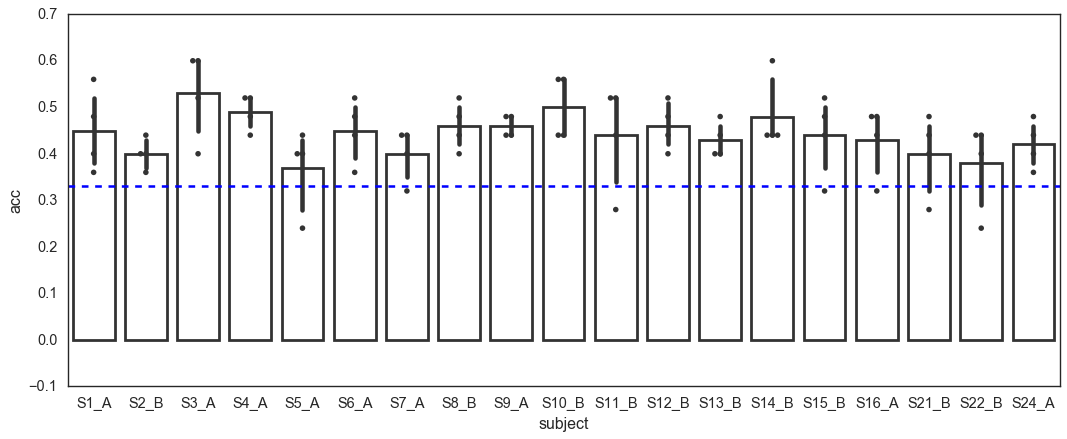

In [36]:
sns.set(style="white", context="talk")
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.barplot(x="subject", y="acc", data=nn_long_df,linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".2", edgecolor=".2")
x = sns.swarmplot(x="subject", y="acc", data=nn_long_df, color=".2")
plt.axhline(0.33,ls = 'dashed')


# Run specific

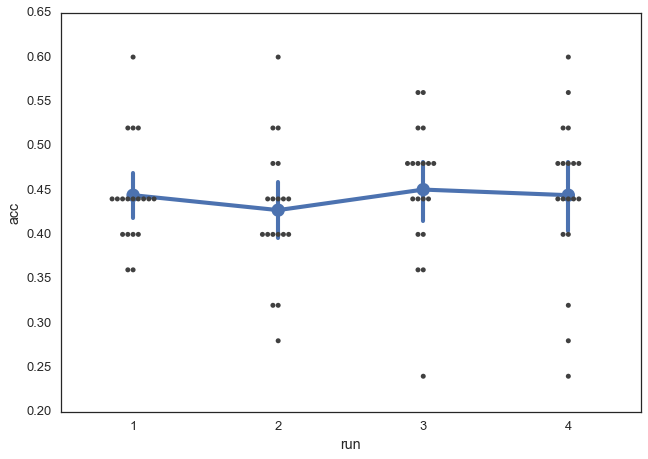

In [38]:
sns.set(style="white", context="talk")
ax = sns.pointplot(x="run", y="acc", data=nn_long_df)
x = sns.swarmplot(x="run", y="acc", data=nn_long_df, color=".25")


# City specific accuracy

In [79]:
nn_scores_ind_copy = nn_scores_ind_df.copy()

In [80]:
#build data frames
nn_scores_ind_copy.head(5)           
nn_scores_ind_copy['acc'] = 0
perf = nn_scores_ind_copy.city == nn_scores_ind_df.city_pred
# nn_scores_ind_df.loc[nn_scores_ind_df['acc'][perf]] = 1
nn_scores_ind_copy.loc[perf,'acc'] = 1
nn_scores_ind_copy.head()

,city,city_pred,run,subject,acc
0,2,2,0,S1_A,1
1,2,3,0,S1_A,0
2,1,1,0,S1_A,1
3,1,1,0,S1_A,1
4,2,3,0,S1_A,0


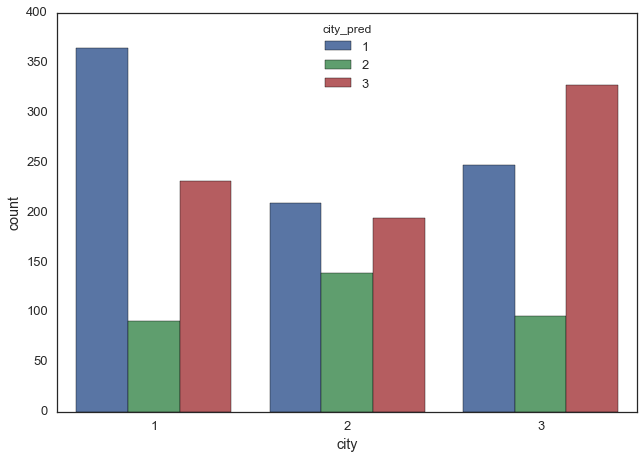

In [81]:
sns.set(style="white", context="talk")
# plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.countplot(x="city", hue="city_pred",data=nn_scores_ind_df)
# x = sns.swarmplot(x="subject", y="acc", data=nn_long_df, color=".2")
# plt.axhline(0.33,ls = 'dashed')


In [84]:
nn_scores_ind_copy.head()

,city,city_pred,run,subject,acc
0,2,2,0,S1_A,1
1,2,3,0,S1_A,0
2,1,1,0,S1_A,1
3,1,1,0,S1_A,1
4,2,3,0,S1_A,0


In [116]:
nn_scores_ind_copy['city']==1


gb =nn_scores_ind_copy.groupby(['subject', 'city'])['acc'].mean()



In [129]:
c1_acc =nn_scores_ind_copy[nn_scores_ind_copy['city']==1].groupby(['subject'])['acc'].mean().values
c2_acc =nn_scores_ind_copy[nn_scores_ind_copy['city']==2].groupby(['subject'])['acc'].mean().values
c3_acc =nn_scores_ind_copy[nn_scores_ind_copy['city']==3].groupby(['subject'])['acc'].mean().values

city_perf_df = pd.DataFrame({'city1'  : c1_acc,
                             'city2'  : c2_acc,
                             'city3'  : c3_acc,})
            
city_perf_long_df = pd.melt(city_perf_df,value_vars=['city1','city2','city3'],value_name = 'acc', var_name = 'city')


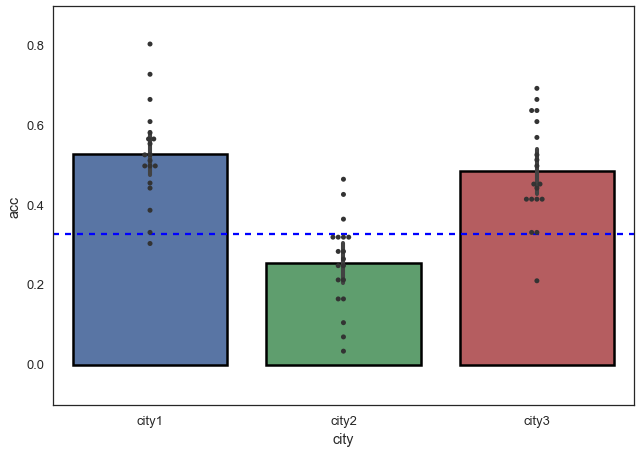

In [132]:
sns.set(style="white", context="talk")
ax = sns.barplot(x="city", y="acc", data=city_perf_long_df,linewidth=2.5)
x = sns.swarmplot(x="city", y="acc", data=city_perf_long_df, color=".2")
plt.axhline(0.33,ls = 'dashed')
